# Classify the Model then Search for answer 

Lets see if we can first predict the tag and then We will add the guessed Tag into the query and then will compare the distances of query and our database.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib
import scipy.sparse
import pickle

In [2]:
con = sqlite3.connect('dataset/processed.db')
processed = pd.read_sql_query("""SELECT * FROM processed""", con)
con.close()

In [3]:
processed = processed.drop(["index"], axis=1)

In [4]:
# processed = processed[processed.Title != ""]
processed.head()

,Title,Body,Tags
0,implementing boundary value analysis software ...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++
1,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
2,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,c#
3,java lang nosuchmethoderror javax servlet serv...,<p>i want to have a servlet to process inputs ...,java
4,specified initialization vector iv match block...,<p>I've had troubles using an CryptoStream for...,c#


In [5]:
labels = {"c#" : 0, "java" : 1, "c++" : 2, "c" : 3, "ios" : 4}
labels_map = { 0 : "c#" , 1 : "java" , 2 : "c++" , 3 : "c", 4 : "ios"}

In [6]:
processed["Tags"] = processed["Tags"].map(labels)

In [7]:
processed.head()

,Title,Body,Tags
0,implementing boundary value analysis software ...,<pre><code>#include&lt;iostream&gt;\n#include&...,2
1,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,0
2,dynamic datagrid binding silverlight,<p>I should do binding for datagrid dynamicall...,0
3,java lang nosuchmethoderror javax servlet serv...,<p>i want to have a servlet to process inputs ...,1
4,specified initialization vector iv match block...,<p>I've had troubles using an CryptoStream for...,0


In [8]:
X = processed.Title.values
y = processed.Tags.values

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train)
X_train.shape, X_test.shape, X_cv.shape

((343506,), (114503,), (114503,))

In [83]:
# On Unigram

In [206]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)
X_train.shape, X_cv.shape, X_test.shape

((343506, 52506), (114503, 52506), (114503, 52506))

In [82]:
from sklearn.metrics.classification import accuracy_score
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1]):
    clf = SGDClassifier(alpha = i, loss = "log", class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

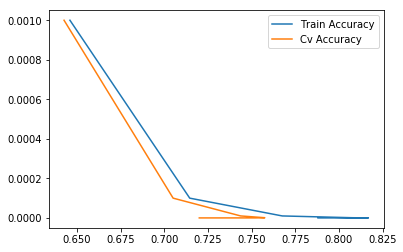

In [92]:
import matplotlib.pyplot as plt
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
plt.plot(score_train[:-2], lis, label = "Train Accuracy")
plt.plot(score_cv[:-2], lis, label = "Cv Accuracy")
plt.legend()
plt.show()

In [103]:
best_alpha = 1e-7

In [137]:
from sklearn.metrics.classification import confusion_matrix
import seaborn as sns
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)

The Accuracy of model is :  0.7585035202040495


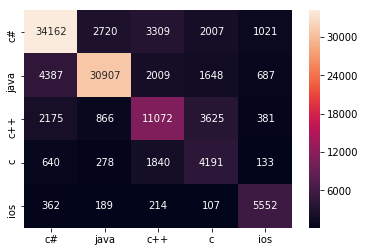

In [101]:
x_ax = ["c#", "java", "c++", "c", "ios"]
y_ax = ["c#", "java", "c++", "c", "ios"]
sns.heatmap(cm, annot = True, fmt="d", xticklabels=x_ax, yticklabels=y_ax)

In [102]:
# We are observing as Maximum of data belongs to c# and Java
# hence it tend to be majority class. Confusion between C and C++

In [ ]:
# Lets See how SVM will perform

In [106]:
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001]):
    clf = SGDClassifier(alpha = i, class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

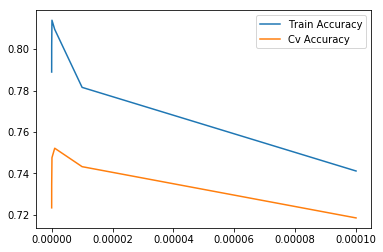

In [113]:
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
plt.plot(lis, score_train, label = "Train Accuracy")
plt.plot(lis, score_cv, label = "Cv Accuracy")
plt.legend()
plt.show()

In [111]:
best_alpha = 1e-6

The Accuracy of model is :  0.7510875072063731


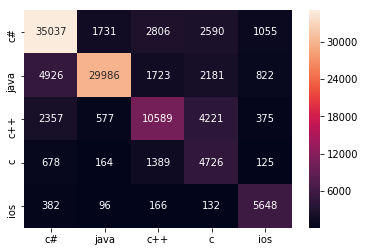

In [112]:
clf = SGDClassifier(alpha = best_alpha, class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)
sns.heatmap(cm, annot = True, fmt="d", xticklabels=x_ax, yticklabels=y_ax)

In [120]:
# Just Similar Kind of Accuracy, Now Lets See If doing bigrams Helps
import random
random.seed(42)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train)
X_train.shape, X_test.shape, X_cv.shape

((343443,), (114482,), (114481,))

In [122]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
X_train = tfidf.fit_transform(X_train)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)
X_train.shape, X_cv.shape, X_test.shape

((343443, 703980), (114481, 703980), (114482, 703980))

In [123]:
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001]):
    clf = SGDClassifier(alpha = i, loss = "log", class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

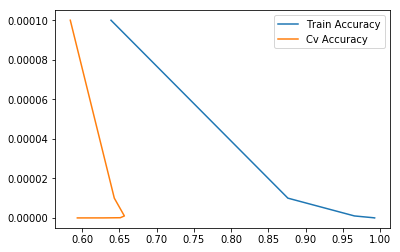

In [124]:
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
plt.plot(score_train, lis, label = "Train Accuracy")
plt.plot(score_cv, lis, label = "Cv Accuracy")
plt.legend()
plt.show()

In [126]:
# CASE OF OVERFITTING
best_alpha = 0.000001

In [127]:
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)

The Accuracy of model is :  0.6587323771422582


In [ ]:
# Hence Bigrams are not useful so no need to go further for checking

In [175]:
# So lets Take our clf_final which is classifier from LR on Unigram

In [9]:
tfidf = TfidfVectorizer()
data = tfidf.fit_transform(processed.Title)
data.shape

(572512, 68851)

In [10]:
scipy.sparse.save_npz('data.npz', data)

In [ ]:
data = scipy.sparse.load_npz('data.npz')

In [11]:
y = processed.Tags.values

In [16]:
filename = 'y'


outfile = open(filename,'wb')
pickle.dump(y,outfile)
outfile.close()

infile = open(filename,'rb')
y = pickle.load(infile)

In [31]:
filename = 'tfidf.sav'
joblib.dump(tfidf, filename)

['tfidf.sav']

In [17]:
clf_final = SGDClassifier(alpha = 1e-7, loss = "log", class_weight="balanced", n_jobs=-1)
clf_final.fit(data, y)

SGDClassifier(alpha=1e-07, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
filename = 'clf_final.sav'
joblib.dump(clf_final, filename)

['clf_final.sav']

In [20]:
clf_final = joblib.load(filename)

In [21]:
query = "global static variable vs static variable function"

In [22]:
# Now we will add this return label into the title and then we will search for
# the Similar queries to see the improvement

In [26]:
def process_query(query):
    preprocessed_reviews = []
    sentance = re.sub("\S*\d\S*", "", query).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords.words('english'))
    preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

def tfidf_search(query):
    query = process_query(query)
    query_trans = tfidf.transform(query)
    pairwise_dist = pairwise_distances(data, query_trans)
    
    indices = np.argsort(pairwise_dist.flatten())[0:10]
    df_indices = list(processed.index[indices])
    return df_indices


def label(query):
    query = process_query(query)
    query = tfidf.transform(query)
    ans = clf_final.predict(query)
    return labels_map[ans[0]]


def change_query(query):
    tag = label(query)
    return query + " " + tag

In [27]:
def enter_queries(query) : 
    print("The Query is :", query)
    query = change_query(query)
    df_indices = tfidf_search(query)
    print("The Model Interpreted Query is :", query)
    print("Top Results : ")
    for i in (df_indices):
        print("Title : ", processed.Title.iloc[i])

In [28]:
query = "synchronization"
enter_queries(query)

The Query is : synchronization
The Model Interpreted Query is : synchronization java
Top Results : 
Title :  java synchronization
Title :  java synchronization
Title :  java synchronization
Title :  synchronization
Title :  java synchronization code
Title :  java array synchronization
Title :  java method synchronization
Title :  synchronization thread java
Title :  thread synchronization java
Title :  java synchronization problem


### Note : We are getting Indices from the Database, Also we have Body of the dataset. We can make an api system where after a query user can redirected to that thread where the body of question is solved

<pre>
In previous notebook where we used only Distances was giving other results related to other languages also but after using Machine learning we can see the results have improved. And are query Oriented.
</pre>

# Future Improvement : 
We can make a web api to do what is mentioned in Note

